In [1]:
import random
import numpy as np
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
model_path = "./deberta_imdb_model"  # <- change if needed
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

In [6]:
dataset = load_dataset("imdb")
test_dataset = dataset["test"].shuffle(seed=42).select(range(7500))

def tokenize(example):
    return tokenizer(example["text"], truncation=True, max_length=512)

test_dataset = test_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/7500 [00:00<?, ? examples/s]

In [7]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds),
    }

training_args = TrainingArguments(
    output_dir="./eval_logs",
    per_device_eval_batch_size=8,
    report_to="none",
    dataloader_drop_last=False,
    seed=42
)

trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [8]:
results = trainer.predict(test_dataset)
preds = np.argmax(results.predictions, axis=1)
labels = results.label_ids

acc = accuracy_score(labels, preds)
f1 = f1_score(labels, preds)

print(f"\nTest Accuracy: {acc:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=["negative", "positive"]))

  0%|          | 0/938 [00:00<?, ?it/s]


Test Accuracy: 0.9605
Test F1 Score: 0.9604

Classification Report:
              precision    recall  f1-score   support

    negative       0.95      0.97      0.96      3732
    positive       0.97      0.95      0.96      3768

    accuracy                           0.96      7500
   macro avg       0.96      0.96      0.96      7500
weighted avg       0.96      0.96      0.96      7500



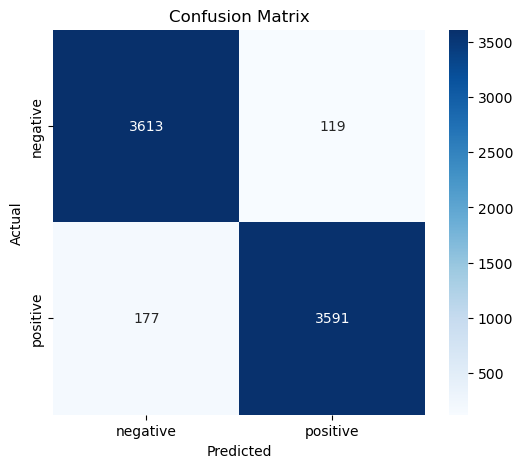

In [9]:
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["negative", "positive"], yticklabels=["negative", "positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()